In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, MaxPooling1D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from keras.layers import LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Disable warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Check TensorFlow version
print(tf.__version__)

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.15.0
Num GPUs Available:  1


In [2]:
# Load data from JSON file
def load_data(filepath):
    return pd.read_csv(filepath)

# Preprocess data
def preprocess_data(df):
    #df['dialect'] = df['dialect'].replace('language', 'general')
    #df['input'] = df['input'].apply(lambda x: x.strip())
    return df

def view_data_balance(df, label_col):
    # Count the number of samples in each class
    class_counts = df[label_col].value_counts()
    # Create a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.xlabel(label_col)
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()
    return class_counts

# Create a balanced dataset
def balance_data(df, label_col, n_samples):
    samples = [df[df[label_col] == label][:n_samples] for label in df[label_col].unique()]
    return pd.concat(samples)

# create a function to shuffle the dataframe
def shuffle_dataframe(df):
    return df.sample(frac=1).reset_index(drop=True)

# vocabulary size
def calculate_vocabulary_size(df, column_name):
    # Tokenize the text into words
    words = df[column_name].str.split().explode().unique()
    # Count the number of unique words
    vocabulary_size = len(words)
    return vocabulary_size

#max_len calculator
def calculate_max_length(df, column_name):
    # Calculate the maximum length of any text entry in the specified column
    max_len = df[column_name].str.split().apply(len).max()
    return max_len

# Tokenization and padding
def tokenize_and_pad(texts, max_len, num_words):
    tokenizer = Tokenizer(num_words=num_words, oov_token="<UNK>")
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    return tokenizer, padded_sequences

# Build the model
def create_model(input_shape, num_classes, vocabulary_size):
    model = Sequential([
        Embedding(input_dim=vocabulary_size+1, output_dim=128, input_length=input_shape),
        Conv1D(384, 3, padding='same', kernel_regularizer=l2(0.01)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.6),
        Conv1D(192, 3, padding='same', kernel_regularizer=l2(0.02)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.45),
        Conv1D(128, 3, padding='same', kernel_regularizer=l2(0.02)),
        LeakyReLU(alpha=0.2),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.55),
        Conv1D(64, 3, padding='same', kernel_regularizer=l2(0.02)),
        LeakyReLU(alpha=0.2),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.55),
        GlobalMaxPooling1D(),
        Dense(256, kernel_regularizer=l2(0.03)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.65),
        # Dense(48, kernel_regularizer=l2(0.03)),
        # LeakyReLU(alpha=0.1),
        # BatchNormalization(),
        # Dropout(0.55),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the model
def train_model(model, X_train, y_train, X_validate, y_validate, epochs, batch_size):
    lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, lr_schedule])
    return history

# Evaluate the model
def evaluate_model(model, X_test, y_test, label_names):
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)
    print(classification_report(true_classes, predicted_classes, target_names=label_names))
    confusion_mtx = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

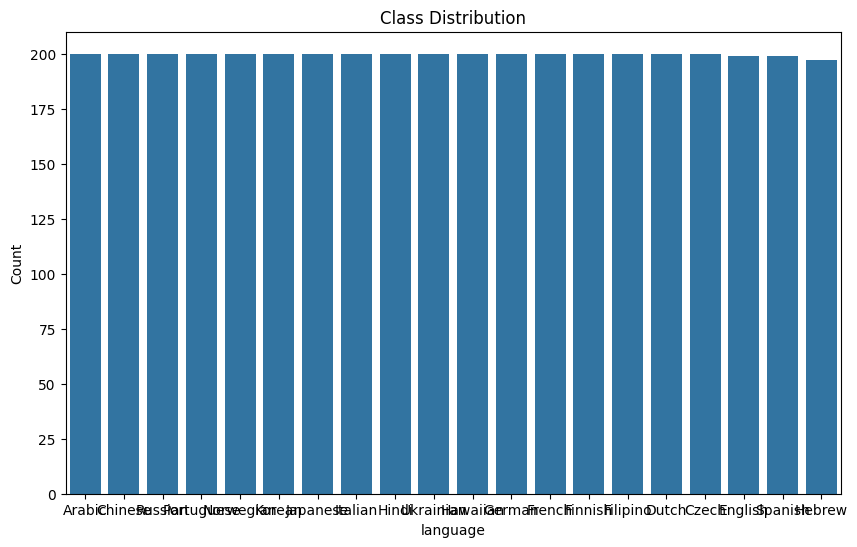

Arabic        200
Chinese       200
Russian       200
Portuguese    200
Norwegian     200
Korean        200
Japanese      200
Italian       200
Hindi         200
Ukrainian     200
Hawaiian      200
German        200
French        200
Finnish       200
Filipino      200
Dutch         200
Czech         200
English       199
Spanish       199
Hebrew        197
Name: language, dtype: int64


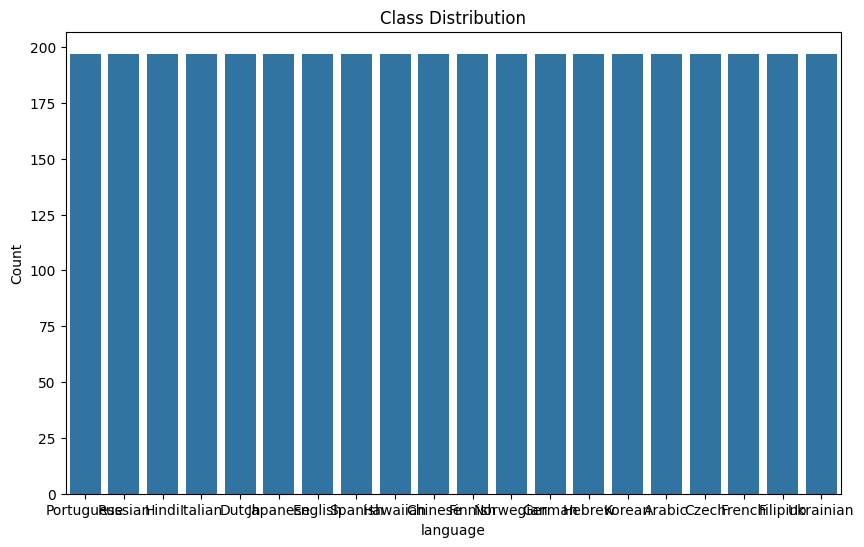

Portuguese    197
Russian       197
Hindi         197
Italian       197
Dutch         197
Japanese      197
English       197
Spanish       197
Hawaiian      197
Chinese       197
Finnish       197
Norwegian     197
German        197
Hebrew        197
Korean        197
Arabic        197
Czech         197
French        197
Filipino      197
Ukrainian     197
Name: language, dtype: int64
Vocabulary size: 8935
Maximum length: 41


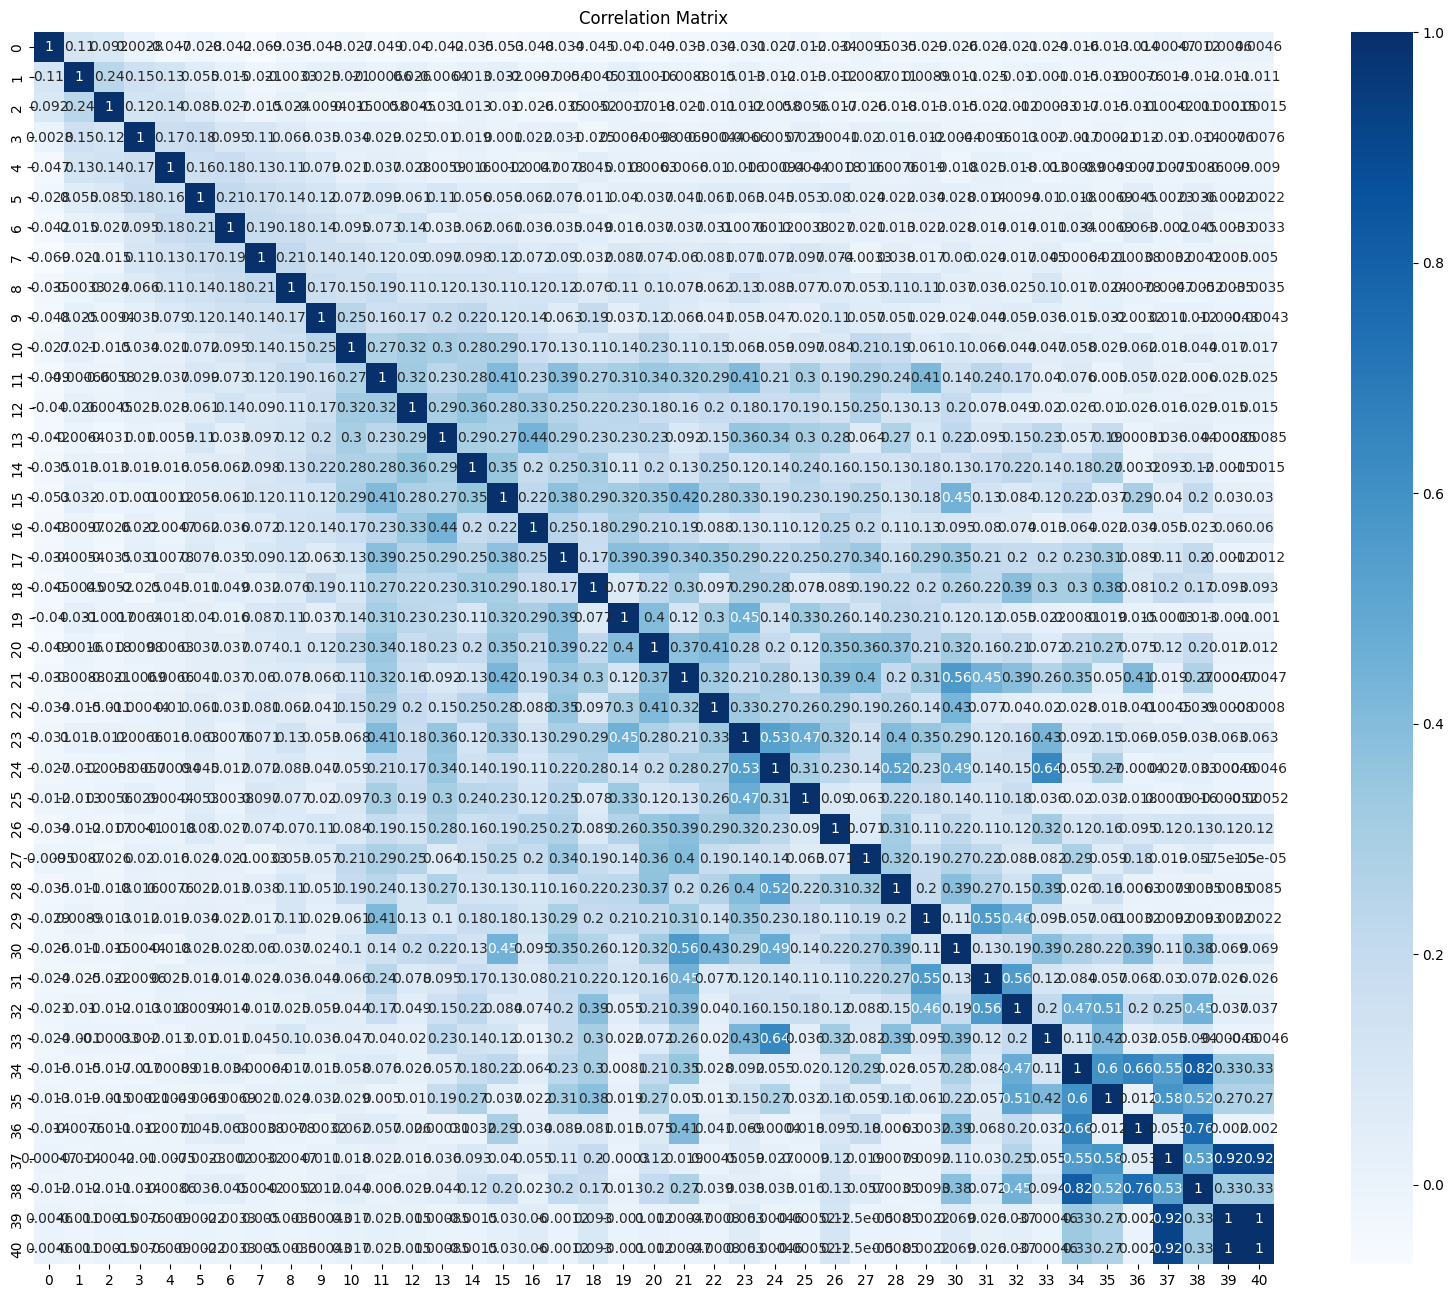

2024-05-25 00:07:05.461374: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-05-25 00:07:05.461401: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-05-25 00:07:05.461410: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-05-25 00:07:05.461441: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-25 00:07:05.461454: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 41, 128)           1143808   
                                                                 
 conv1d (Conv1D)             (None, 41, 384)           147840    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 41, 384)           0         
                                                                 
 batch_normalization (Batch  (None, 41, 384)           1536      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 20, 384)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 20, 384)           0

2024-05-25 00:07:06.794882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


74/74 [==============================] - 8s 74ms/step - loss: 17.9290 - accuracy: 0.0867 - val_loss: 16.0842 - val_accuracy: 0.0635 - lr: 0.0010
Epoch 2/40
74/74 [==============================] - 4s 58ms/step - loss: 14.7040 - accuracy: 0.1294 - val_loss: 14.0723 - val_accuracy: 0.0635 - lr: 0.0010
Epoch 3/40
74/74 [==============================] - 4s 58ms/step - loss: 11.9603 - accuracy: 0.1591 - val_loss: 12.2788 - val_accuracy: 0.0635 - lr: 0.0010
Epoch 4/40
74/74 [==============================] - 4s 57ms/step - loss: 9.6415 - accuracy: 0.2035 - val_loss: 10.9873 - val_accuracy: 0.0635 - lr: 0.0010
Epoch 5/40
74/74 [==============================] - 4s 58ms/step - loss: 7.8044 - accuracy: 0.2618 - val_loss: 10.0770 - val_accuracy: 0.0635 - lr: 0.0010
Epoch 6/40
74/74 [==============================] - 4s 59ms/step - loss: 6.4295 - accuracy: 0.3266 - val_loss: 9.4853 - val_accuracy: 0.0635 - lr: 0.0010
Epoch 7/40
74/74 [==============================] - 4s 59ms/step - loss: 5.2454

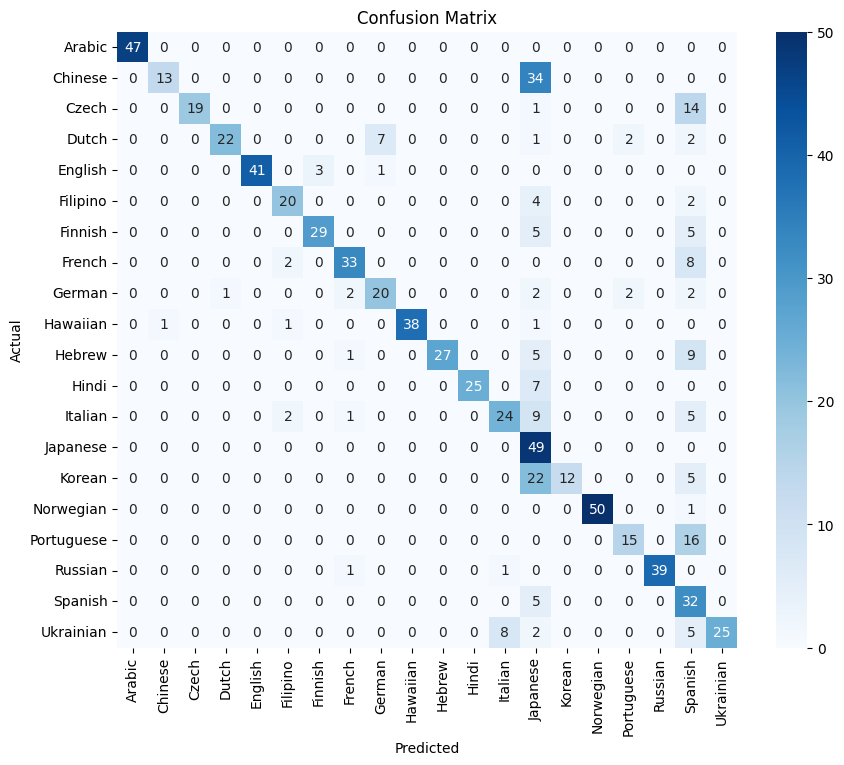

In [3]:
# Main execution block
if __name__ == "__main__":
    epochs = 40
    batch_size = 32
    # Load and preprocess data
    df = load_data('data/languages.csv')
    df = preprocess_data(df)

    # view data balance
    class_counts = view_data_balance(df, 'language')
    print(class_counts)
    
    # # based on the data balance, create a balanced dataset of the same size as the smallest class = 13187
    df = balance_data(df, 'language', 197)
    
    # # shuffle the dataframe
    df = shuffle_dataframe(df)
    df = shuffle_dataframe(df)
    
    # # view data balance
    class_counts = view_data_balance(df, 'language')
    print(class_counts)

    # # calculate the vocabulary size and max_len
    vocabulary_size = calculate_vocabulary_size(df, 'input')
    print(f'Vocabulary size: {vocabulary_size}')

    max_len = calculate_max_length(df, 'input')
    print(f'Maximum length: {max_len}')

    # # Tokenization and encoding labels
    tokenizer, X_padded = tokenize_and_pad(df['input'],max_len,vocabulary_size)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(df['language'])
    y_categorical = to_categorical(y_encoded)

    # # create a correlaton matrix for y_encoded
    corr = pd.DataFrame(X_padded).corr()
    plt.figure(figsize=(20, 16))
    sns.heatmap(corr, annot=True, cmap='Blues')
    plt.title('Correlation Matrix')
    plt.show()

    # # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)
    X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    # # Model creation and training
    model = create_model(X_train.shape[1], y_train.shape[1], vocabulary_size)
    model.summary()
    history = train_model(model, X_train, y_train, X_validate, y_validate, epochs, batch_size)

    # # Model evaluation
    evaluate_model(model, X_test, y_test, label_encoder.classes_)

In [4]:
# model.save('model_weights.h5')

# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('label_encoder.pickle', 'wb') as handle:
#     pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
    